### Import Libraries

In [41]:
import re
import lxml
import preprocessor as p 
import pandas as pd 
import numpy as np

import unicodedata
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score 
from sklearn.metrics import confusion_matrix # Digunakan untuk membuat confusion matrix
from sklearn.metrics import plot_confusion_matrix # Digunakan untuk menggambarkan confusion matrix

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from html import unescape

### Import Data

In [3]:
# training data
train = pd.read_csv('datd_train.csv')

# test data
test = pd.read_csv('datd_test.csv')

# slang data
slang = pd.read_csv('kamus-alay-master/colloquial-indonesian-lexicon.csv', usecols=['slang', 'formal'])

In [4]:
train.head()

,text,label
0,"oh pantesan tadi pada rame, ternyata monek mau...",0
1,"Semakin bertambah usia, semakin cemas hidup.",0
2,gelisah bgt astaga,1
3,Udah jangan terlalu cemas sikapku tak berubah ...,0
4,Giliran Aldebaran diambang kematian...Semua ba...,0


In [5]:
test.head()

,text,label
0,"ngga enak bgt akhir2 ini rasanya, sering cemas...",1
1,Sedikit khawatir dan gelisah. 😓,1
2,Ngelakuin kesalahan yang sama. Bodoh bgt. Udah...,1
3,"Pantesan gelisah bae, lupa lgi ga ada duit🤭",0
4,Semoga Mei disertai kabar-kabar baik. Yang luk...,0


In [6]:
slang.head()

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa


### Data Exploration

In [7]:
# checking train data label

train['label'].value_counts()

0    1468
1     733
Name: label, dtype: int64

In [8]:
# checking test data label

test['label'].value_counts()

0    389
1    161
Name: label, dtype: int64

In [9]:
# checking null data in training data
print(train.isnull().sum())

text     0
label    0
dtype: int64


In [10]:
# checking null data in test data
print(test.isnull().sum())

text     0
label    0
dtype: int64


### Data Cleaning

In [11]:
# memproses dataframe slang, diubah ke dictionary
slang_unique = slang['slang'].unique()
slang_grouped = slang.groupby('slang')
slang_list = []

for word in slang_unique:
    ls = [word, slang_grouped.get_group(word).iloc[0, 1]]
    slang_list.append(ls)

slang_dict = {x[0]:x[1] for x in slang_list}

In [12]:
# fungsi untuk mereplace kata slang dengan kata baku

def slang_replace(string):
    new_string = " ".join(slang_dict.get(word, word) for word in string.split(' '))
    return new_string


In [13]:
# atur tanda baca (punctuation) yang ingin dihilangkan

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:)|(\.\.+)")

In [14]:
# fungsi untuk ambil emoji dan memproses ke dalam bentuk teks

def capture_emoji(string):
    emot_list = re.findall(r'[^\w\s,.]', string)

    emot_string = ' '.join(emot_list)

    return emot_string

In [15]:
# fungsi untuk mengubah emoji ke dalam bentuk ASCII

def deEmojify(inputString):
    returnString = ""

    for character in inputString:
        try:
            character.encode("ascii")
            returnString += character
        except UnicodeEncodeError:
            replaced = unidecode(str(character))
            if replaced != '':
                returnString += replaced
            else:
                try:
                     returnString += "[" + unicodedata.name(character).replace(' ', '-') + "]"
                except ValueError:
                     returnString += "[x]"


    return returnString

In [16]:
# fungsi untuk filter kata

def filter_string(string, stopword):
    stop = stopword.remove(string)
    tokens = word_tokenize(stop)
    return ' '.join(tokens)

# print(filter_string('Sedikit khawatir dan gelisah'))

In [17]:
# fungsi untuk cleaning dataset (kombinasi tweet_preprocessor dan reguar expression)
def clean_tweets(df):
  stemmer = StemmerFactory().create_stemmer()
  stopword = StopWordRemoverFactory().create_stop_word_remover()
  tempArr = []
  for line in df:
    # ambil emoji dan proses ke dalam ASCII
    emot_string = deEmojify(capture_emoji(line))

    # kirim tweet_processor
    tmpL = p.clean(line)

    # menghilangkan karakter spesial HTML
    soup = BeautifulSoup(unescape(tmpL), 'lxml')
    tmpL = soup.text
    
    # menghilangkan punctuation/tanda baca
    tmpL = REPLACE_WITH_SPACE.sub(' ', tmpL)
    tmpL = REPLACE_NO_SPACE.sub('', tmpL.lower()) # konvert semua kata dalam tweet ke lowercase

    # menghilangkan angka dan URL
    tmpL = re.sub('https://t.co/\S*', '', tmpL)
    tmpL = re.sub("[0-9]","",tmpL)
    
    # filter kata
    tmpL = filter_string(tmpL,stopword)

    # mengganti kata slang ke kata baku
    tmpL = slang_replace(tmpL)

    # stemming kata
    tmpL = stemmer.stem(tmpL)

    # hasil akhir kalimat yang disimpan dengan menambahkan emoji kembali
    tmpL = tmpL + ' ' + emot_string

    tempArr.append(tmpL)
  return tempArr

In [18]:
# membersihkan data training

train_clean = clean_tweets(train['text'])
train_clean = pd.DataFrame(train_clean)
train_clean.head()

,0
0,pantesan tadi rame nyata monek mau coba juni c...
1,makin tambah usia makin cemas hidup
2,gelisah banget astaga
3,sudah jangan terlalu cemas sikap tak ubah rasa...
4,gilir aldebaran ambang mati semua baru ingat j...


In [19]:
# menggabungkan data bersih ke train dataframe

train['clean'] = train_clean
train.tail(10)

,text,label,clean
2191,Gak pernah kelewat buat nguatin diri sendiri k...,1,enggak pernah lewat buat nguatin diri sendiri ...
2192,Ini gelisah bngttt dri kemarin mikirkan bntr l...,1,gelisah banget dari kemarin mikirkan bentar kl...
2193,Jika kamu masih cemas setelah berdoa. Maka kam...,0,kamu cemas doa kamu butuh lebih banyak waktu doa
2194,Resah dan gelisah,1,resah gelisah
2195,&lt;-- oknum sedang gundah gelisah nggak sabar...,0,oknum sedang gundah gelisah sabar lihat ill be...
2196,hey please boleh minta kata kata positif or se...,1,hey please minta kata kata positif orang seman...
2197,ekpektasimu mematahkanmu.harapmu tak sesuai ke...,0,ekpektasimu mematahkanmuharapmu tak sesuai kei...
2198,"Rasa takut , cemas dan tiba tiba deg deg an te...",0,rasa takut cemas tiba tiba deg deg an terus te...
2199,"Rakyat merasa tenang ada FPI, malah gelisah ad...",0,rakyat rasa tenang fpi malah gelisah polisi ja...
2200,Lagi lagi saya cemas sama tlp yg masuk ke hp.,0,lagi cemas sama telepon yang masuk hp


In [25]:
train['clean'].iloc[2192]

'gelisah banget dari kemarin mikirkan bentar kls siap sbm masih sedikitt banyak banget yang khawatir [DIZZY-FACE]'

In [20]:
# membersihkan data test

test_clean = clean_tweets(test['text'])
test_clean = pd.DataFrame(test_clean)
test_clean.head()

,0
0,enggak enak banget akhir rasa sering cemas lebih
1,sedikit khawatir gelisah [FACE-WITH-COLD-SWEAT]
2,laku salah sama bodoh banget sudah bulan rasa ...
3,pantesan gelisah bae lupa lagi enggak duit [SM...
4,moga mei serta kabar kabar baik luka lekas pul...


In [21]:
# menggabungkan data bersih ke test dataframe

test['clean'] = test_clean
test.head(10)

,text,label,clean
0,"ngga enak bgt akhir2 ini rasanya, sering cemas...",1,enggak enak banget akhir rasa sering cemas lebih
1,Sedikit khawatir dan gelisah. 😓,1,sedikit khawatir gelisah [FACE-WITH-COLD-SWEAT]
2,Ngelakuin kesalahan yang sama. Bodoh bgt. Udah...,1,laku salah sama bodoh banget sudah bulan rasa ...
3,"Pantesan gelisah bae, lupa lgi ga ada duit🤭",0,pantesan gelisah bae lupa lagi enggak duit [SM...
4,Semoga Mei disertai kabar-kabar baik. Yang luk...,0,moga mei serta kabar kabar baik luka lekas pul...
5,Sebagian besar anak muda yang akan super sukse...,0,bagi besar anak muda akan super sukses masa de...
6,"Heal! Halo, Ada yg pernah coba meditasi mindfu...",0,heal halo yang pernah coba meditasi mindfullne...
7,Kayanya w gabisa minum kopi hari ini krna lagi...,0,kaya gue enggak bisa minum kopi hari karena ge...
8,"Jika hatimu merasa gelisah, berbaringlah dalam...",0,hati rasa gelisah baring sunyi jika hati mu la...
9,kok gue gelisah terus kenapaya,1,kok gue gelisah terus kenapaya


### Test and Train Split

In [59]:
# Split data test dan train dengan ratio 2:8
X_train = train['clean'].copy().to_numpy()
X_test = test['clean'].copy().to_numpy()
y_train = train['label'].copy().to_numpy().reshape(-1, 1)
y_test = test['label'].copy().to_numpy().reshape(-1, 1)

X_concat = pd.concat([train['clean'], test['clean']], ignore_index=True).to_numpy()
y_concat = pd.concat([train['label'], test['label']], ignore_index=True).to_numpy().reshape(-1, 1)

### Vectorize Tweets using TFIDFVectorizer

##### TFIDF 

In [57]:
# vectorize tweets for model building
vectorizer = TfidfVectorizer(binary=False, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(X_train) + list(X_test))

# transform documents to document-term matrix
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# transform concat data for cross validation
X_concat_vec = vectorizer.fit_transform(X_concat)


### Model Building

In [115]:
# classify using support vector classifier
clf_svm = SVC(kernel='rbf', probability=True, C=10, gamma=0.1)

# fit the SVC model based on the given training data
clf_svm.fit(X_train_vec, y_train.ravel())

# perform classification and prediction on samples in x_test
y_pred_svm = clf_svm.predict(X_test_vec)

In [116]:
# perform classification and prediction on samples in x_test
y_pred_svm = clf_svm.predict(X_test_vec)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


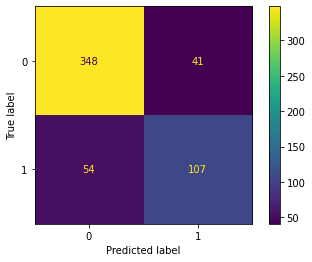

In [119]:
# confusion matrix

cm = plot_confusion_matrix(clf_svm, X_test_vec, y_test, values_format='d', display_labels=['0', '1'])

In [120]:
cm.figure_.savefig('cm.png', dpi=300)

In [ ]:
# Accuracy score

print("Accuracy score for SVC is: ", accuracy_score(y_test, y_pred_svm) * 100, '%')

### Using Cross Validation

In [100]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # C harus > 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001],
    'degree': [2, 3, 4],
    'kernel': ['poly']}
]

optimal_params = GridSearchCV(
    SVC(), 
    param_grid, 
    cv=5,
    scoring='f1',
    verbose=0 # Jika ingin melihat bagaimana Grid Search bekerja, set verbose = 2
)

optimal_params.fit(X_concat_vec, y_concat.ravel())
print(optimal_params.best_params_)

{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [101]:
pd.set_option('display.max_columns', None)

# results = pd.DataFrame(optimal_params.cv_results_)[['rank_test_score', 'param_C', 
# 'param_gamma', 'param_kernel', 'mean_test_score']].sort_values(by=['rank_test_score'])
# results.set_index(['rank_test_score'], inplace=True)

results = pd.DataFrame(optimal_params.cv_results_).sort_values(by=['rank_test_score'])

results.set_index(['rank_test_score'], inplace=True)

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,0.588688,0.017780,0.128510,0.001832,10,2,1,poly,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.513208,0.557621,0.520446,0.530466,0.585714,0.541491,0.026759
1,0.583472,0.006576,0.133318,0.009300,10,2,scale,poly,"{'C': 10, 'degree': 2, 'gamma': 'scale', 'kern...",0.513208,0.557621,0.520446,0.530466,0.585714,0.541491,0.026759
3,0.587216,0.009812,0.128118,0.001230,100,2,scale,poly,"{'C': 100, 'degree': 2, 'gamma': 'scale', 'ker...",0.498113,0.550186,0.518519,0.526690,0.591549,0.537011,0.031967
3,0.589609,0.018528,0.129208,0.002489,100,2,1,poly,"{'C': 100, 'degree': 2, 'gamma': 1, 'kernel': ...",0.498113,0.550186,0.518519,0.526690,0.591549,0.537011,0.031967
5,0.573619,0.009047,0.131242,0.002451,100,2,0.1,poly,"{'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel'...",0.449799,0.510121,0.445344,0.509506,0.536398,0.490234,0.036189
5,0.580097,0.016948,0.135596,0.006943,1,2,1,poly,"{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'p...",0.449799,0.510121,0.445344,0.509506,0.536398,0.490234,0.036189
7,0.611272,0.026741,0.143420,0.017550,1,2,scale,poly,"{'C': 1, 'degree': 2, 'gamma': 'scale', 'kerne...",0.449799,0.510121,0.445344,0.509506,0.534351,0.489824,0.035672
8,0.594007,0.006600,0.131346,0.001668,10,3,scale,poly,"{'C': 10, 'degree': 3, 'gamma': 'scale', 'kern...",0.321429,0.380531,0.378855,0.363636,0.381356,0.365161,0.022807
8,0.591735,0.004773,0.132633,0.002700,10,3,1,poly,"{'C': 10, 'degree': 3, 'gamma': 1, 'kernel': '...",0.321429,0.380531,0.378855,0.363636,0.381356,0.365161,0.022807


In [102]:
# fungsi untuk evaluasi model

def evaluation_data(results):
    evaluation_dict = {
        'accuracy': [],
        'f1': [],
        'recall': [],
        'precision': []
    }
    for index in range(0, results.shape[0]):
        # classify using support vector classifier (RBF, Sigmoid)
        # clf_svm = SVC(kernel=results['param_kernel'].iloc[index], probability=True, 
        # C=results['param_C'].iloc[index], gamma=results['param_gamma'].iloc[index])

        # # classify using support vector classifier (Linear)
        # clf_svm = SVC(kernel=results['param_kernel'].iloc[index], probability=True, 
        # C=results['param_C'].iloc[index])

        # classify using support vector classifier (Polynomial)
        clf_svm = SVC(kernel=results['param_kernel'].iloc[index], probability=True, 
        C=results['param_C'].iloc[index], gamma=results['param_gamma'].iloc[index], 
        degree=results['param_degree'].iloc[index])

        # fit the SVC model based on the given training data
        clf_svm.fit(X_train_vec, y_train.ravel())

        # perform classification and prediction on samples in x_test
        y_pred_svm = clf_svm.predict(X_test_vec)

        # add accuracy score, f1 score, recall score, precision score to list
        evaluation_dict['accuracy'].append(accuracy_score(y_test, y_pred_svm))
        evaluation_dict['f1'].append(f1_score(y_test, y_pred_svm))
        evaluation_dict['recall'].append(recall_score(y_test, y_pred_svm))
        evaluation_dict['precision'].append(precision_score(y_test, y_pred_svm))

    return evaluation_dict

In [103]:
# menjalankan fungsi evaluasi

evaluation_dict_tmpL = evaluation_data(results)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

In [104]:
# masukan hasil perhitungan dictionary pada dataframe results

results['accuracy'] = evaluation_dict_tmpL['accuracy']
results['f1'] = evaluation_dict_tmpL['f1']
results['recall'] = evaluation_dict_tmpL['recall']
results['precision'] = evaluation_dict_tmpL['precision']

In [105]:
# cek hasil

results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,accuracy,f1,recall,precision
rank_test_score,,,,,,,,,,,,,,,,,,,,
1,0.588688,0.017780,0.128510,0.001832,10,2,1,poly,"{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': '...",0.513208,0.557621,0.520446,0.530466,0.585714,0.541491,0.026759,0.805455,0.596226,0.490683,0.759615
1,0.583472,0.006576,0.133318,0.009300,10,2,scale,poly,"{'C': 10, 'degree': 2, 'gamma': 'scale', 'kern...",0.513208,0.557621,0.520446,0.530466,0.585714,0.541491,0.026759,0.805455,0.596226,0.490683,0.759615
3,0.587216,0.009812,0.128118,0.001230,100,2,scale,poly,"{'C': 100, 'degree': 2, 'gamma': 'scale', 'ker...",0.498113,0.550186,0.518519,0.526690,0.591549,0.537011,0.031967,0.812727,0.619926,0.521739,0.763636
3,0.589609,0.018528,0.129208,0.002489,100,2,1,poly,"{'C': 100, 'degree': 2, 'gamma': 1, 'kernel': ...",0.498113,0.550186,0.518519,0.526690,0.591549,0.537011,0.031967,0.812727,0.619926,0.521739,0.763636
5,0.573619,0.009047,0.131242,0.002451,100,2,0.1,poly,"{'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel'...",0.449799,0.510121,0.445344,0.509506,0.536398,0.490234,0.036189,0.801818,0.547718,0.409938,0.825000
5,0.580097,0.016948,0.135596,0.006943,1,2,1,poly,"{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'p...",0.449799,0.510121,0.445344,0.509506,0.536398,0.490234,0.036189,0.801818,0.547718,0.409938,0.825000
7,0.611272,0.026741,0.143420,0.017550,1,2,scale,poly,"{'C': 1, 'degree': 2, 'gamma': 'scale', 'kerne...",0.449799,0.510121,0.445344,0.509506,0.534351,0.489824,0.035672,0.801818,0.547718,0.409938,0.825000
8,0.594007,0.006600,0.131346,0.001668,10,3,scale,poly,"{'C': 10, 'degree': 3, 'gamma': 'scale', 'kern...",0.321429,0.380531,0.378855,0.363636,0.381356,0.365161,0.022807,0.761818,0.401826,0.273292,0.758621
8,0.591735,0.004773,0.132633,0.002700,10,3,1,poly,"{'C': 10, 'degree': 3, 'gamma': 1, 'kernel': '...",0.321429,0.380531,0.378855,0.363636,0.381356,0.365161,0.022807,0.761818,0.401826,0.273292,0.758621


In [106]:
# eksport hasil dataframe ke excel

results.to_excel(results['param_kernel'].iloc[0] + '.xlsx')